# Classifying Emotions

This notebook for preprocessing data, feature extraction, and classification with LDA. Model parameters, feature extraction, and other preprocessing code will most likely be exported to external .py file for final project pipeline for online classification. Outputs of LDA model will be fed into art visualizer

In [1]:
import numpy as np
import pandas as pd
import json
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, sosfilt, stft, welch
from scipy.integrate import simps
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
import pickle
from joblib import dump, load

In [2]:
eeg_data_path = '../DataCollection/data/eeg_data/'
emotion_data_path = '../DataCollection/data/emotion_data/'

## Band pass all eeg data 0-30Hz 

Using scipy's butterworth filter

### Visualize filtering one of the eeg first

In [3]:
data_len = 15360

In [4]:
samp_data = np.zeros((3,data_len)) # only doing one file for now

In [5]:
with open(eeg_data_path + 'user1song1.json') as jsonfile:
    dd = json.load(jsonfile)
    samp_data[0,:] = dd['raw_eeg']
    samp_data[1,:] = dd['attention']
    samp_data[2,:] = dd['meditation']

In [6]:
# define filter parameters
fs = 128 # sampling rate
hp = 0.1
lp = 30
order = 3

# filter
sos = butter(order, [hp, lp], analog = False, btype = 'band', output = 'sos', fs = fs)

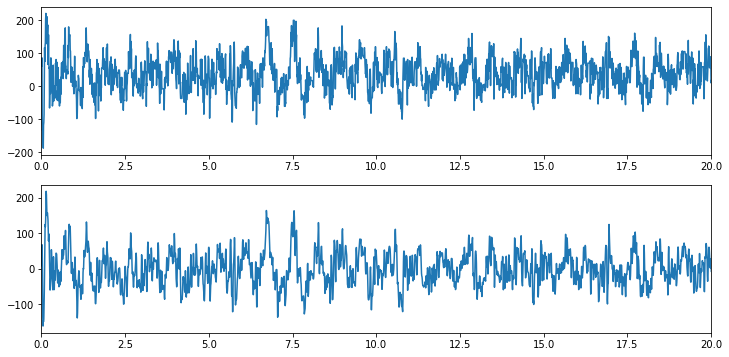

In [7]:
filtered_eeg = sosfilt(sos, samp_data[0,:])

fig,ax = plt.subplots(2,1, figsize=(12,6))

ax[0].plot(np.arange(0,120,1/fs), samp_data[0,:])
ax[1].plot(np.arange(0,120,1/fs), filtered_eeg)
ax[0].set_xlim([0,20])
ax[1].set_xlim([0,20])
plt.show()

#### View spectrogram

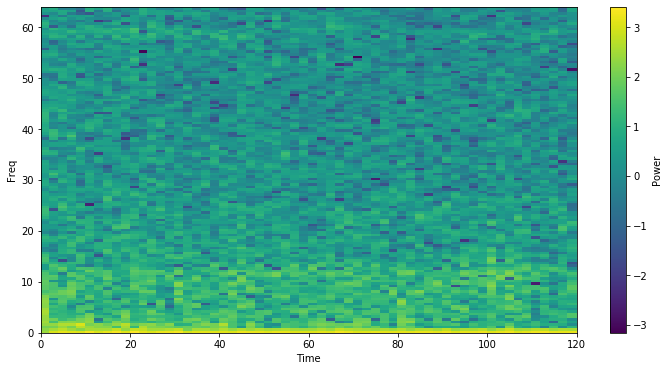

In [8]:
f,t,Z = stft(samp_data[0,:], fs=fs, nperseg=2*fs, noverlap=0)
plt.figure(figsize=(12,6))
plt.pcolor(t, f, np.log10(np.abs(Z)**2))
plt.colorbar(label='Power')
plt.xlabel('Time')
plt.ylabel('Freq')
plt.show()

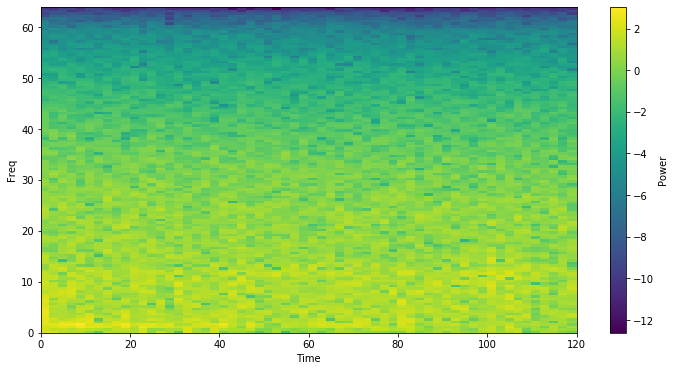

In [9]:
f,t,Z = stft(filtered_eeg, fs=fs, nperseg=2*fs, noverlap=0)
plt.figure(figsize=(12,6))
plt.pcolor(t, f, np.log10(np.abs(Z)**2))
plt.colorbar(label='Power')
plt.xlabel('Time')
plt.ylabel('Freq')
plt.show()

### Collect and filter all data

In [10]:
def butter_filter(raw_eeg):
    
    # define filter parameters
    fs = 128 # sampling rate
    hp = 0.1
    lp = 30
    order = 3

    # filter
    sos = butter(order, [hp, lp], analog = False, btype = 'band', output = 'sos', fs = fs)
    filtered = sosfilt(sos, raw_eeg)
    
    return filtered

In [11]:
# num samples minus ipynb checkpoints file in dir
n_samples = len(os.listdir(eeg_data_path)) - 1

# collect eeg data
eeg_data = np.zeros((n_samples, 3, data_len)) # (34, 3, 15360)

for i,filename in enumerate(sorted(os.listdir(eeg_data_path)), start=-1):
    if '.ipynb' in filename:
        continue
    
    with open(eeg_data_path + filename) as jsonfile:
        eeg = json.load(jsonfile)
        # filter raw eeg
        raw_filt = butter_filter(eeg['raw_eeg'])
        
        # add all 3 features to data
        eeg_data[i,0,:] = raw_filt
        eeg_data[i,1,:] = eeg['attention']
        eeg_data[i,2,:] = eeg['meditation']

In [12]:
# collect emotion data
emotion_data = np.zeros((n_samples, 12))

s = 0
for i,filename in enumerate(sorted(os.listdir(emotion_data_path))):
    if '.ipynb' in filename:
        continue
    
    emotion = pd.read_csv(emotion_data_path + filename, index_col=0)
    emotion = np.array(emotion)[:,2:]
    
    if i == 6 or i == 7: # 2 trials
        emotion = np.repeat(emotion, 2, axis=0)
    
    emotion_data[s:s+emotion.shape[0],:] = emotion
    s = s + emotion.shape[0]

In [13]:
eeg_data.shape, emotion_data.shape

((34, 3, 15360), (34, 12))

## Feature Extraction

Features:

* mean voltage
* voltage variance  - STD
* average attention
* average meditation
* relative power of:
    * delta band (1-4 Hz)
    * theta band (4-8 Hz)
    * alpha band (8-12 Hz)
    * beta band (12-30 Hz)
* ? first order diff (averaged)?
* see if there's any other significant features
    
**may need to normalize features**

### Extracting/viz features for 1 training example

blue = relaxed,
red = energized

In [14]:
# can play around w/ different samples- change index
seeg = eeg_data[0]
semotion = emotion_data[0]

In [15]:
nper_chunk = fs * 10
seegn = seeg.reshape(3, 12, nper_chunk)

In [16]:
# mean/std of voltage
m_volt = np.mean(seegn[0], axis=1)
std_volt = np.std(seegn[0], axis=1)

# mean attention/meditation as percentages
m_att = np.mean(seegn[1], axis=1) / 100
m_med = np.mean(seegn[2], axis=1) / 100

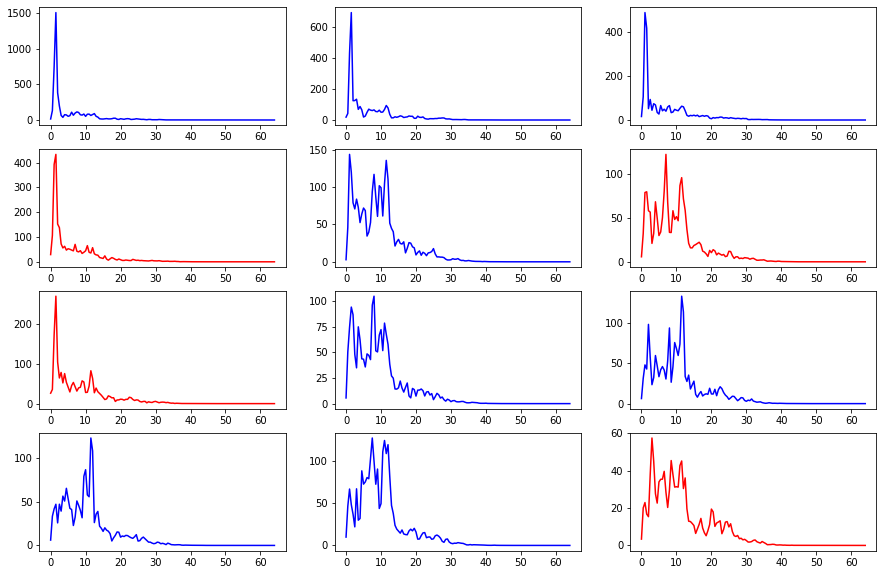

In [17]:
# power spectrum of each segment
fig,ax = plt.subplots(4,3, figsize=(15,10))
c = ['b', 'r']

for i in range(12):
    eeg = seegn[0][i]
    freqs, psd = welch(eeg, fs=fs)
    ax[int(i/3),i%3].plot(freqs,psd, color=c[int(semotion[i])])


In [18]:
# relative power of each frequency band
delta = [1,4]
theta = [4,8]
alpha = [8,12]
beta = [12,30]

relative_powers = []
for seg in range(12):
    
    powers = []
    
    freqs, psd = welch(seegn[0][seg], fs=fs)
    freq_res = freqs[1] - freqs[0]
    total_power = simps(psd, dx=freq_res)
    
    for band in [delta,theta,alpha,beta]:
        band_idx = np.logical_and(freqs >= band[0], freqs < band[1])
        b_power = simps(psd[band_idx], dx=freq_res)
        
        powers.append(b_power / total_power)
    
    relative_powers.append(powers)

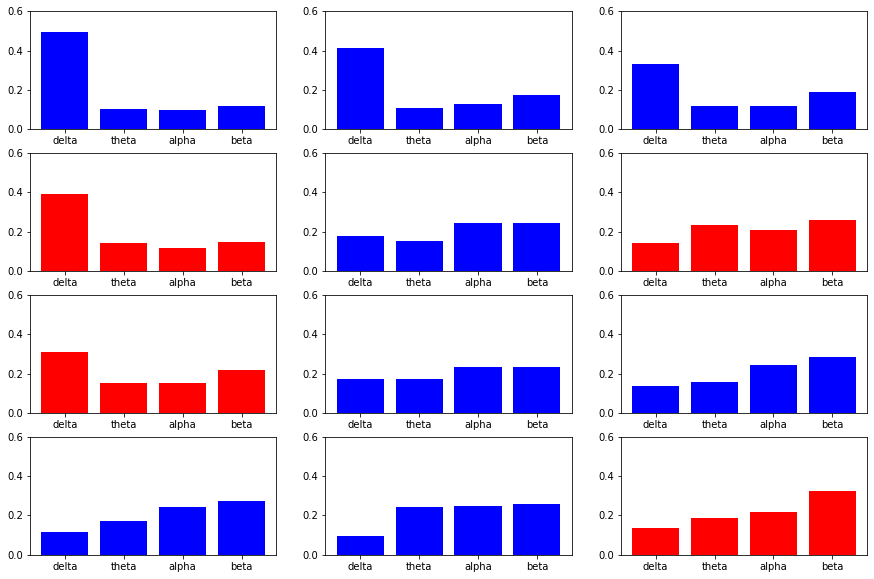

In [19]:
fig,ax = plt.subplots(4,3, figsize=(15,10))

for i in range(12):
    ax[int(i/3),i%3].bar(range(4),relative_powers[i], color=c[int(semotion[i])])
    ax[int(i/3),i%3].set_xticklabels([0,'delta','theta','alpha','beta'])
    ax[int(i/3),i%3].set_ylim([0,0.6])

### Extract all X (features) for LDA model

In [20]:
def extract_features(sample):
    """ 
    Extracts the following features from a sample into an array:
        mean voltage
        std of voltage
        mean % attention
        mean % meditation
        relative delta power
        relative theta power
        relative alpha power
        relative beta power
        
    parameter
    ---------
        sample: must be 3 x 1280 array
    returns
    --------
        features: length 8 list containing 8 features
    """
    
    features = np.zeros(8)
    
    # mean/std of voltage
    features[0] = np.mean(sample[0])
    features[1] = np.std(sample[0])

    # mean attention/meditation as percentages
    features[2] = np.mean(sample[1]) / 100
    features[3] = np.mean(sample[2]) / 100
    
    # relative powers for each band
    delta = [1,4]
    theta = [4,8]
    alpha = [8,12]
    beta = [12,30]

    freqs, psd = welch(sample[0], fs=fs)
    freq_res = freqs[1] - freqs[0]
    total_power = simps(psd, dx=freq_res)

    for i,band in enumerate([delta,theta,alpha,beta], start=4):
        band_idx = np.logical_and(freqs >= band[0], freqs < band[1])
        b_power = simps(psd[band_idx], dx=freq_res)

        features[i] = b_power / total_power

    return features

In [21]:
# get all features and targets
nper_chunk = fs * 10
X = []
for samp in eeg_data:
    seg = samp.reshape(3, 12, nper_chunk)
    
    for i in range(12):
        X.append(extract_features(seg[:,i,:]))

X = np.array(X)
# # normalize mean and variance
# X[:,:2] = normalize(X[:,:2], norm='l1')
y = emotion_data.flatten()

In [22]:
X.shape, y.shape

((408, 8), (408,))

### Which features are actually meaningful?

In [23]:
df_X = pd.DataFrame(X)
df_X.columns = ['mean-volt', 'var-volt', 'attn', 'med', 'delta', 'theta', 'alpha', 'beta']
df_X['label'] = y.astype(int)
df_X

,mean-volt,var-volt,attn,med,delta,theta,alpha,beta,label
0,-0.000887,53.745087,0.664781,0.477414,0.495540,0.104559,0.099645,0.120536,0
1,0.491131,39.711584,0.906430,0.574555,0.411260,0.110975,0.126805,0.174060,0
2,-0.410955,36.829700,0.844719,0.496461,0.330968,0.119572,0.119884,0.188658,0
3,-0.556687,36.624169,0.737875,0.414875,0.394231,0.140870,0.116810,0.147916,1
4,0.212822,36.278798,0.579367,0.643461,0.177162,0.154587,0.244521,0.246681,0
...,...,...,...,...,...,...,...,...,...
403,0.346701,33.703774,0.179336,0.914062,0.268512,0.157924,0.133059,0.232356,1
404,-0.663867,33.944014,0.303523,0.628172,0.255551,0.222283,0.139145,0.240012,1
405,0.181100,32.204057,0.374063,0.653148,0.244573,0.138420,0.146015,0.338014,1
406,0.819576,43.107154,0.223602,0.735609,0.240033,0.144589,0.168439,0.278948,1


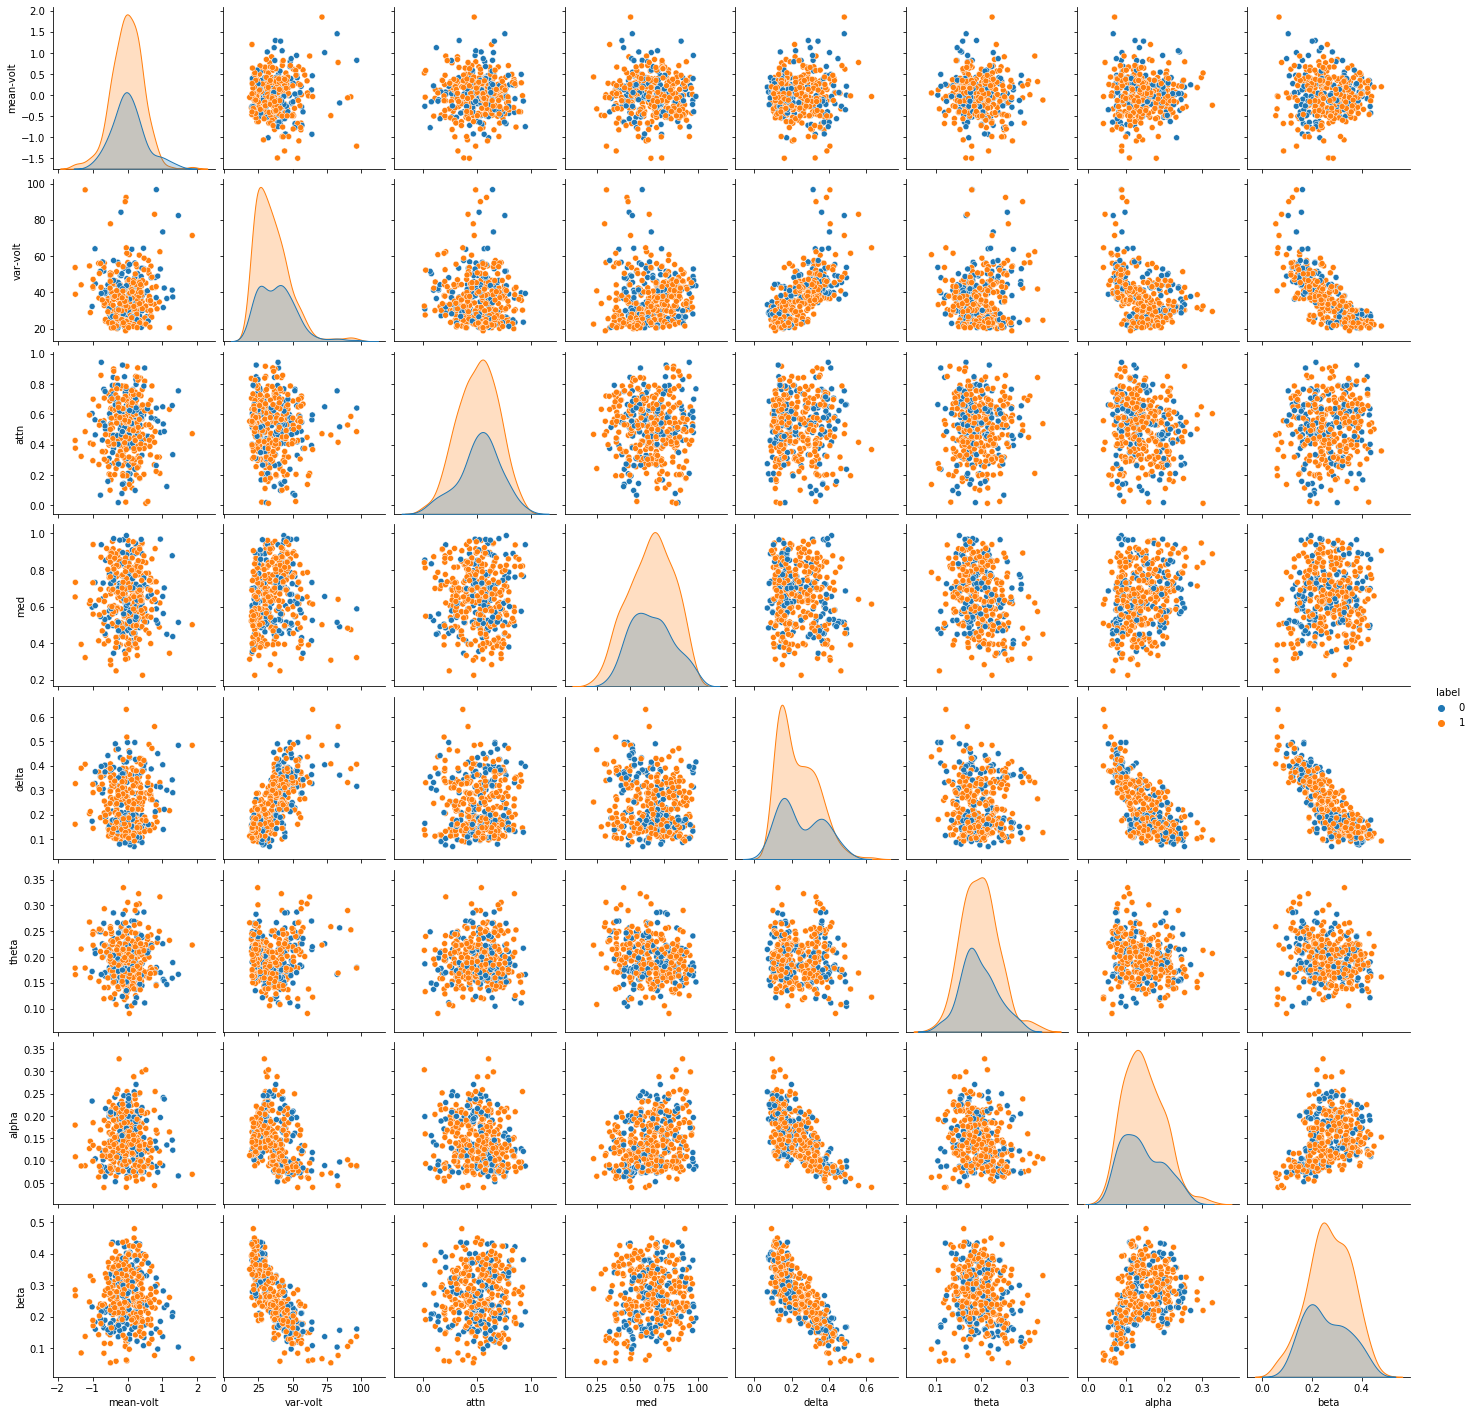

In [24]:
sns.pairplot(df_X, hue='label')

## LDA classifier

In [24]:
X_train = np.array([])
X_test = np.array([])
y_train = np.array([])
y_test = np.array([])
for i in np.arange(0,408,12):
    X_train = np.append(X_train, X[i:i+9,:])
    X_test = np.append(X_test, X[i+9:i+11,:])
    y_train = np.append(y_train, y[i:i+9])
    y_test = np.append(y_test, y[i+9:i+11])

In [25]:
X_train = X_train.reshape(-1, 8)
X_test = X_test.reshape(-1, 8)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((306, 8), (68, 8), (306,), (68,))

In [27]:
len(y_train[np.where(y_train == 0)]), len(y_train[np.where(y_train == 1)])

(109, 197)

In [28]:
xx,yy = resample(X_train[np.where(y_train == 0)], y_train[np.where(y_train == 0)], n_samples=80, random_state=0)

In [29]:
X_train = np.append(X_train, xx).reshape(-1, 8)
y_train = np.append(y_train, yy)

In [30]:
X_train.shape, y_train.shape

((386, 8), (386,))

In [31]:
len(y_train[np.where(y_train == 0)]), len(y_train[np.where(y_train == 1)])

(189, 197)

In [32]:
X_train.shape

(386, 8)

In [33]:
# loaded model

In [34]:
lda_loaded_model = pickle.load(open('lda_model.pkl', 'rb'))

In [36]:
# test
y_pred = lda_loaded_model.predict(X_test)
lda_loaded_model.score(X_test, y_test)

0.6176470588235294

In [37]:
# accuracy metrics
print('Accuracy: {}'.format(metrics.accuracy_score(y_pred, y_test)))
print('Precision: {}'.format(metrics.precision_score(y_pred, y_test)))
print('Recall: {}'.format(metrics.recall_score(y_pred, y_test)))
print('F1: {}'.format(metrics.f1_score(y_pred, y_test)))

print('\nConfusion Matrix\n{}'.format(metrics.confusion_matrix(y_pred, y_test)))

Accuracy: 0.6176470588235294
Precision: 0.6981132075471698
Recall: 0.7872340425531915
F1: 0.74

Confusion Matrix
[[ 5 16]
 [10 37]]


In [35]:
# train
LDA = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
LDA.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
                           solver='lsqr', store_covariance=False, tol=0.0001)

In [36]:
# test
y_pred = LDA.predict(X_test)
LDA.score(X_test, y_test)

0.6176470588235294

In [37]:
# accuracy metrics
print('Accuracy: {}'.format(metrics.accuracy_score(y_pred, y_test)))
print('Precision: {}'.format(metrics.precision_score(y_pred, y_test)))
print('Recall: {}'.format(metrics.recall_score(y_pred, y_test)))
print('F1: {}'.format(metrics.f1_score(y_pred, y_test)))

print('\nConfusion Matrix\n{}'.format(metrics.confusion_matrix(y_pred, y_test)))

Accuracy: 0.6176470588235294
Precision: 0.6981132075471698
Recall: 0.7872340425531915
F1: 0.74

Confusion Matrix
[[ 5 16]
 [10 37]]


In [39]:
# save current instance to mem
pickle.dump(LDA, open('lda_model.pkl', 'wb'))

### Try using ensemble methods

In [41]:
LDA = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

Bagging = BaggingClassifier(base_estimator=LDA, n_estimators=30, 
                           max_samples=80, max_features=4, bootstrap=True, bootstrap_features=True).fit(X_train, y_train)

In [42]:
y_pred_bag = Bagging.predict(X_test)

Bagging.score(X_test, y_test)

0.6176470588235294

In [43]:
# accuracy metrics
print('Accuracy: {}'.format(metrics.accuracy_score(y_pred_bag, y_test)))
print('Precision: {}'.format(metrics.precision_score(y_pred_bag, y_test)))
print('Recall: {}'.format(metrics.recall_score(y_pred_bag, y_test)))
print('F1: {}'.format(metrics.f1_score(y_pred_bag, y_test)))

print('\nConfusion Matrix\n{}'.format(metrics.confusion_matrix(y_pred_bag, y_test)))

Accuracy: 0.6176470588235294
Precision: 0.7169811320754716
Recall: 0.7755102040816326
F1: 0.7450980392156863

Confusion Matrix
[[ 4 15]
 [11 38]]
